In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

import os

In [2]:
in_submission = os.path.exists('/flags/isgrader.flag')
perform_computation = not in_submission 

if in_submission:
    assert os.path.exists('./cifar_net.pth'), 'The trained network for CIFAR was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'
    
    assert os.path.exists('./mnist_net.pth'), 'The trained network for MNIST was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'

# *Assignment Summary

Go through the CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, and ensure you can run the code. Modify the architecture that is offered in the CIFAR-10 tutorial to get the best accuracy you can. Anything better than about 93.5% will be comparable with current research. 

Redo the same efforts for the MNIST digit data set.

**Procedural Instructions**:

This assignment is less guided than the previous assignments. You are supposed to train a deep convolutional classifier, and store it in a file. The autograder will load the trained model, and test its accuracy on a hidden test data set. Your classifier's test accuracy will determine your grade for each part according to the following model.

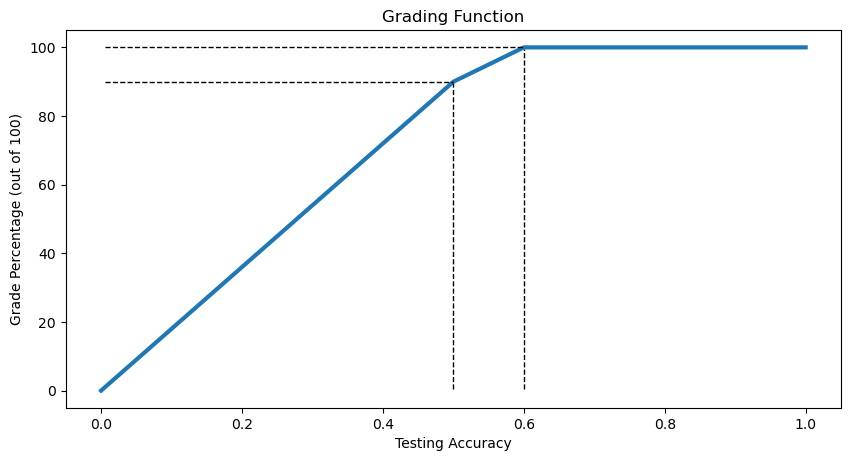

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot([0., 0.5, 0.6, 1.], [0., 90., 100., 100.], lw=3)
ax.axhline(y=90, xmin=0.05, xmax=.5, lw=1, ls='--', c='black')
ax.axvline(x=0.5, ymin=0.05, ymax=.86, lw=1, ls='--', c='black')
ax.axhline(y=100, xmin=0.05, xmax=.59, lw=1, ls='--', c='black')
ax.axvline(x=0.6, ymin=0.05, ymax=.95, lw=1, ls='--', c='black')
ax.set_xlabel('Testing Accuracy')
ax.set_ylabel('Grade Percentage (out of 100)')
ax.set_title('Grading Function')
None

# <span style="color:red">Important Notes</span>

You **should** read these notes before starting as these notes include crucial information about what is expected from you.

1. **Use Pytorch**: The autograder will only accept pytorch models.

  * Pytorch's CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html is the best starting point for this assignment. However, we will not prohibit using or learning from any other tutorial you may find online.


2. **No Downloads**: The coursera machines are disconnected from the internet. We already have downloaded the pytorch data files, and uploaded them for you. You will need to disable downloading the files if you're using data collector APIs such as `torchvision.datasets`.
  * For the CIFAR data, you should provide the `root='/home/jovyan/work/release/CNN-lib/data_cifar', download=False` arguments to the `torchvision.datasets.CIFAR10` API.
  * For the MNIST data, you should provide the `root='/home/jovyan/work/release/CNN-lib/data_mnist', download=False` arguments to the `torchvision.datasets.MNIST` API.


3. **Store the Trained Model**: The autograder can not and will not retrain your model. You are supposed to train your model, and then store your best model with the following names:

  * The CIFAR classification model must be stored at `./cifar_net.pth`. 
  * The MNIST classification model must be stored at `./mnist_net.pth`.
  * Do not place these file under any newly created directory.
  * The trained model may **not exceed 1 MB** in size.


4. **Model Class Naming**: The neural models in the pytorch library are subclasses of the `torch.nn.Module` class. While you can define any architecture as you please, your `torch.nn.Module` must be named `Net` exactly. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```


5. **Grading Reference Pre-processing**: We will use a specific randomized transformation for grading that can be found in the `Autograding and Final Tests` section. Before training any model for long periods of time, you need to pay attention to the existence of such a testing pre-processing.

6. **Training Rules**: You are able to make the following decisions about your model:

  * You **can** choose and change your architecture as you please. 
      * You can have shallow networks, or deep ones.
      * You can customize the number of neural units in each layer and the depth of the network.
      * You are free to use convolutional, and non-convolutional layers.
      * You can employ batch normalization if you would like to.
      * You can use any type of non-linear layers as you please. `Tanh`, `Sigmoid`, and `ReLU` are some common activation functions.
      * You can use any kind of pooling layers you deem appropriate.
      * etc.
   * You **can** initialize your network using any of the methods described in `https://pytorch.org/docs/stable/nn.init.html`.
      * Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.
      * You may want to avoid initializing your network with all zeros (think about the symmetry of the neural units, and how identical initialization may be a bad idea considering what happens during training).
   * You **can** use and customize any kind of optimization methods you deem appropriate.
      * You can use any first order stochastic methods (i.e., Stochastic Gradient Descent variants) such as Vanilla SGD, Adam, RMSProp, Adagrad, etc.
      * You are also welcome to use second order optimization methods such as newton and quasi-newton methods. However, it may be expensive and difficult to make them work for this setting.
      * Zeroth order methods (i.e., Black Box methods) are also okay (although you may not find them very effective in this setting).
      * You can specify any learning rates first order stochastic methods. In fact, you can even customize your learning rate schedules.
      * You are free to use any mini-batch sizes for stochastic gradient computation.
      * etc.
   * You **can** use any kind of loss function you deem effective.
      * You can add any kind of regularization to your loss.
      * You can pick any kind of classification loss functions such as the cross-entropy and the mean squared loss. 
   * You **cannot** warm-start your network (i.e., you **cannot** use a pre-trained network).
   * You **may** use any kind of image pre-processing and transformations during training. However, for the same transformations to persist at grading time, you may need to apply such transformations within the neural network's `forward` function definition. 
      * In other words, we will drop any `DataLoader` or transformations that your network may rely on to have good performance, and we will only load and use your neural network for grading.

# 1. Object Classification Using the CIFAR Data

## 1.1 Loading the Data

In [4]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# your code here
batch_size = 4
data_root = '/home/jovyan/work/release/CNN-lib/data_cifar'

transform_train = transforms.Compose([
    transforms.RandomAffine(
        degrees=30,
        translate=(0.01, 0.01),
        scale=(0.9, 1.1),
        resample=False, 
        fillcolor=0
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).


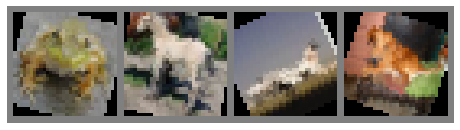

frog  horse plane dog  


In [5]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# your code here
def imshow(img, title=None, verbose=False):
    if verbose:
        print(f"Image shape: {img.shape}")
    img = img / 2 + 0.5 
    npimg = img.cpu().numpy() 
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 1.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [6]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)

# your code here
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

You can define the neural architecture and instantiate it in this cell.


# 1.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [7]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

# your code here
#raise NotImplementedError

You can initialize the neural weights here, and not leave it to the library default (this is optional).


# 1.4 Defining The Loss Function and The Optimizer

In [8]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# your code here
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

You can define the loss function and the optimizer of interest here.


# 1.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [9]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    
    # your code here
    num_epochs = 20

    for epoch in range(num_epochs): 
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % 2000 == 0:
                print(f'[Epoch {epoch + 1}, Mini-batch {i + 1}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

You can define the training loop and forward-backward propagation here.
[Epoch 1, Mini-batch 2000] loss: 2.176
[Epoch 1, Mini-batch 4000] loss: 1.834
[Epoch 1, Mini-batch 6000] loss: 1.674
[Epoch 1, Mini-batch 8000] loss: 1.609
[Epoch 1, Mini-batch 10000] loss: 1.542
[Epoch 1, Mini-batch 12000] loss: 1.498
[Epoch 2, Mini-batch 2000] loss: 1.438
[Epoch 2, Mini-batch 4000] loss: 1.421
[Epoch 2, Mini-batch 6000] loss: 1.400
[Epoch 2, Mini-batch 8000] loss: 1.389
[Epoch 2, Mini-batch 10000] loss: 1.361
[Epoch 2, Mini-batch 12000] loss: 1.348
[Epoch 3, Mini-batch 2000] loss: 1.299
[Epoch 3, Mini-batch 4000] loss: 1.301
[Epoch 3, Mini-batch 6000] loss: 1.277
[Epoch 3, Mini-batch 8000] loss: 1.282
[Epoch 3, Mini-batch 10000] loss: 1.260
[Epoch 3, Mini-batch 12000] loss: 1.249
[Epoch 4, Mini-batch 2000] loss: 1.199
[Epoch 4, Mini-batch 4000] loss: 1.208
[Epoch 4, Mini-batch 6000] loss: 1.194
[Epoch 4, Mini-batch 8000] loss: 1.207
[Epoch 4, Mini-batch 10000] loss: 1.187
[Epoch 4, Mini-batch 120

# 1.6 Storing the Model

**Important Note**: In order for the autograder not to overwrite your model with empty (untrained) model, please make sure you wrap your code within the following conditional statement:

```
if perform_computation:
   # Save your trained model here
    
```

In [10]:
message = 'Here you should store the model at "./cifar_net.pth" .'
print(message)

if perform_computation:
    # your code here
    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)

Here you should store the model at "./cifar_net.pth" .


# 1.7 Evaluating the Trained Model

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


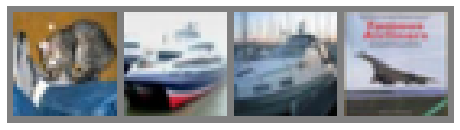

GroundTruth: cat   ship  ship  plane


In [11]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# your code here
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print('GroundTruth:', ' '.join(f'{classes[label]:5s}' for label in labels))

In [13]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# your code here
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')

Here you can evaluate the overall accuracy of the trained classifier (this is optional).
Accuracy of the network on the 10000 test images: 65.16%


In [14]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# your code here
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        correct = (predictions == labels)

        for class_idx in range(len(classes)):
            class_mask = (labels == class_idx)
            total_pred[classes[class_idx]] += class_mask.sum().item()
            correct_pred[classes[class_idx]] += (correct & class_mask).sum().item()

for classname, correct_count in correct_pred.items():
    total = total_pred[classname]
    accuracy = 100 * float(correct_count) / total if total > 0 else 0
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Here you can evaluate the per-class accuracy of the trained classifier (this is optional).
Accuracy for class: plane is 60.4 %
Accuracy for class: car   is 76.1 %
Accuracy for class: bird  is 56.0 %
Accuracy for class: cat   is 45.8 %
Accuracy for class: deer  is 59.2 %
Accuracy for class: dog   is 65.7 %
Accuracy for class: frog  is 68.5 %
Accuracy for class: horse is 64.4 %
Accuracy for class: ship  is 84.7 %
Accuracy for class: truck is 70.8 %


## 1.8 Autograding and Final Tests

In [15]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                  'Make sure you read and follow the instructions provided as Important Notes' + \
                                  '(especially, the "Model Class Naming" part).'

cifar_net_path = './cifar_net.pth'

assert os.path.exists(cifar_net_path), 'You have not stored the trained model properly. '+  \
                                       'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(cifar_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'



if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(cifar_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

test_pre_tranformation = transforms.Compose(transformation_list)

cifar_root = '/home/jovyan/work/release/CNN-lib/data_cifar' 
testset = torchvision.datasets.CIFAR10(root=cifar_root, train=False,
                                       download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

Accuracy of plane : 57 %
Accuracy of   car : 69 %
Accuracy of  bird : 50 %
Accuracy of   cat : 45 %
Accuracy of  deer : 55 %
Accuracy of   dog : 61 %
Accuracy of  frog : 65 %
Accuracy of horse : 63 %
Accuracy of  ship : 83 %
Accuracy of truck : 69 %
----------
Overall Testing Accuracy: 62.2 %%


In [ ]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# 2. Digit Recognition Using the MNIST Data

## 2.1 Loading the Data

In [17]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

classes = list(str(i) for i in range(10))

# your code here
transformation_list = [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize([0.5], [0.5])]

test_pre_transformation = transforms.Compose(transformation_list)


transform = transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5], [0.5])])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='/home/jovyan/work/release/CNN-lib/data_mnist', train=True, 
                                      download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='/home/jovyan/work/release/CNN-lib/data_mnist', train=False, 
                                     download=False, transform=test_pre_transformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).
image shape is:  torch.Size([4, 1, 28, 28])


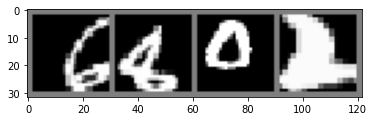

6     8     0     2    


In [18]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# your code here
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy() 
    transposed = np.transpose(npimg, (1, 2, 0))
    plt.imshow(transposed)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
print("image shape is: ", images.shape)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 2.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [19]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)


# your code here
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

You can define the neural architecture and instantiate it in this cell.


# 2.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [20]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

# your code here
#raise NotImplementedError

You can initialize the neural weights here, and not leave it to the library default (this is optional).


# 2.4 Defining The Loss Function and The Optimizer

In [21]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# your code here
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

You can define the loss function and the optimizer of interest here.


# 2.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [22]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    
    # your code here
    num_epochs = 20
    print_freq = 2000  

    for epoch in range(num_epochs):
        net.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i + 1) % print_freq == 0:
                avg_loss = running_loss / print_freq
                print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] Loss: {avg_loss:.3f}')
                running_loss = 0.0

        epoch_loss = running_loss / (i + 1) if i < print_freq else running_loss / print_freq
        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch + 1} Summary - Loss: {epoch_loss:.3f}, Accuracy: {epoch_acc:.2f}%')

    print('Finished Training')

You can define the training loop and forward-backward propagation here.
[Epoch 1, Batch  2000] Loss: 1.818
[Epoch 1, Batch  4000] Loss: 1.244
[Epoch 1, Batch  6000] Loss: 1.064
[Epoch 1, Batch  8000] Loss: 0.914
[Epoch 1, Batch 10000] Loss: 0.810
[Epoch 1, Batch 12000] Loss: 0.718
[Epoch 1, Batch 14000] Loss: 0.647
Epoch 1 Summary - Loss: 0.284, Accuracy: 66.89%
[Epoch 2, Batch  2000] Loss: 0.575
[Epoch 2, Batch  4000] Loss: 0.552
[Epoch 2, Batch  6000] Loss: 0.485
[Epoch 2, Batch  8000] Loss: 0.465
[Epoch 2, Batch 10000] Loss: 0.431
[Epoch 2, Batch 12000] Loss: 0.440
[Epoch 2, Batch 14000] Loss: 0.399
Epoch 2 Summary - Loss: 0.196, Accuracy: 85.32%
[Epoch 3, Batch  2000] Loss: 0.384
[Epoch 3, Batch  4000] Loss: 0.358
[Epoch 3, Batch  6000] Loss: 0.357
[Epoch 3, Batch  8000] Loss: 0.343
[Epoch 3, Batch 10000] Loss: 0.347
[Epoch 3, Batch 12000] Loss: 0.323
[Epoch 3, Batch 14000] Loss: 0.312
Epoch 3 Summary - Loss: 0.158, Accuracy: 89.30%
[Epoch 4, Batch  2000] Loss: 0.310
[Epoch 4, Batc

# 2.6 Storing the Model

**Important Note**: In order for the autograder not to overwrite your model with empty (untrained) model, please make sure you wrap your code within the following conditional statement:

```
if perform_computation:
   # Save your trained model here
    
```

In [23]:
message = 'Here you should store the model at "./mnist_net.pth" .'
print(message)

if perform_computation:
    # your code here
    PATH = './mnist_net.pth'
    torch.save(net.state_dict(), PATH)

Here you should store the model at "./mnist_net.pth" .


# 2.7 Evaluating the Trained Model

In [24]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# your code here
#raise NotImplementedError

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


In [25]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# your code here
#raise NotImplementedError

Here you can evaluate the overall accuracy of the trained classifier (this is optional).


In [26]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# your code here
#raise NotImplementedError

Here you can evaluate the per-class accuracy of the trained classifier (this is optional).


## 2.8 Autograding and Final Tests

In [27]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                 'Make sure you read and follow the instructions provided as Important Notes' + \
                                 '(especially, the "Model Class Naming" part).'

mnist_net_path = './mnist_net.pth'

assert os.path.exists(mnist_net_path), 'You have not stored the trained model properly. ' + \
                                      'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(mnist_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'

if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(mnist_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]

test_pre_tranformation = transforms.Compose(transformation_list)

mnist_root = '/home/jovyan/work/release/CNN-lib/data_mnist' 
testset = torchvision.datasets.MNIST(root=mnist_root, train=False,
                                     download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

Accuracy of     0 : 91 %
Accuracy of     1 : 77 %
Accuracy of     2 : 67 %
Accuracy of     3 : 68 %
Accuracy of     4 : 57 %
Accuracy of     5 : 60 %
Accuracy of     6 : 78 %
Accuracy of     7 : 43 %
Accuracy of     8 : 68 %
Accuracy of     9 : 58 %
----------
Overall Testing Accuracy: 67.25 %%


In [ ]:
# "Digit Recognition Test: Checking the accuracy on the MNIST Images"
